In [1]:
import ecog_data
import prediction
import torch
import torch.nn as nn
import torch.nn.functional as F

import wandb
import pytorch_lightning as ptl
from pytorch_lightning.loggers.wandb import WandbLogger
from pytorch_lightning.tuner.batch_size_scaling import scale_batch_size

import os

import matplotlib.pyplot as plt

In [2]:
config_dict = {
    'lr': 5e-4,
    'lr_factor': 0.5,
    'src_len': 50,
    'trg_len': 50,
    'batch_size': 1000,
    'encoder_size': 256,
    'encoder_layers': 1,
    'generator_size': 256,
    'generator_layers': 1,
    'factor_size': 64,
    'loss_weight_dict': {
        'ayy': 'lmao',
    },
    'dropout': 0.3,
}

In [3]:
# configure wandb
wandb.init(
    config = config_dict,
    mode = 'disabled'
)
wandb_logger = WandbLogger(name='ah-jeez',project='lfads')

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


In [4]:
# configure data module
ldm = ecog_data.GooseWireless250(
    wandb.config.src_len,
    wandb.config.trg_len,
    wandb.config.batch_size
)
ldm.prepare_data()
ldm.setup()

In [5]:
model = prediction.Lfads(
    src_size            = ldm.size()[-1],
    encoder_size        = wandb.config.encoder_size,
    encoder_layers      = wandb.config.encoder_layers,
    generator_size      = wandb.config.generator_size,
    generator_layers    = wandb.config.generator_layers,
    factor_size         = wandb.config.factor_size,
    loss_weight_dict    = wandb.config.loss_weight_dict,
    dropout             = wandb.config.dropout,
    learning_rate       = wandb.config.lr,
    lr_factor           = wandb.config.lr_factor
)

In [6]:
trainer = ptl.Trainer(max_epochs=100, logger=wandb_logger, gpus=1)
# trainer.tune(model,ldm)
# scale_batch_size(trainer,model,init_val=1024,max_trials=3)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [7]:
# trainer.fit(model)

In [8]:
src, trg = iter(ldm.train_dataloader()).__next__()
pred_dict = model(src,trg)

In [41]:
e1 = nn.Sequential(
    nn.Conv2d(1,5,(9,1),stride=1,padding=(4,0),padding_mode='replicate'),
    nn.BatchNorm2d(5),
    nn.ELU(),
    nn.Dropout(0.3)
) 
e2 = nn.Sequential(
    nn.Conv2d(5,5,(1,42),stride=1),
    nn.BatchNorm2d(5),
    nn.ELU(),
    nn.Dropout(0.3)
)
e3 = nn.Sequential(
    nn.AvgPool2d((2,1),stride=2),
    nn.Flatten()
)
z_mean = nn.Linear(125,10)
z_logvar = nn.Linear(125,10)
d1 = nn.Linear(10,125)
d2 = nn.Upsample((50,1))
d3 = nn.Sequential(
    nn.ConvTranspose2d(5,5,(1,42),stride=1),
    nn.BatchNorm2d(5),
    nn.ELU(),
    nn.Dropout(0.3)
)
d4 = nn.Sequential(
    nn.ConvTranspose2d(5,1,(9,1),stride=1,padding=(4,0),padding_mode='zeros'),
    nn.BatchNorm2d(1),
    nn.ELU(),
    nn.Dropout(0.3)
)
def _sample_gaussian(mean,logvar):
    eps = torch.randn(mean.shape, requires_grad=False, dtype=torch.float32)
    return torch.exp(logvar*0.5)*eps + mean

In [44]:
e_out = e3(e2(e1(src.unsqueeze(1))))
z_mean_draw = z_mean(e_out)
z_logvar_draw = z_logvar(e_out)
z_sample = _sample_gaussian(z_mean_draw,z_logvar_draw)
d_out = d4(d3(d2(d1(z_sample).view(1000,5,25,1))))
pred = d_out.squeeze(1)

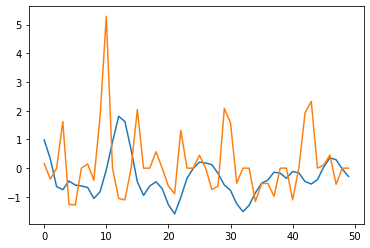

In [49]:
plt.plot(trg[0,:,10])
plt.plot(pred[0,:,10].detach().numpy())